In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
import sys as sys
import time
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT

In [2]:
g = [1, 2, 3, 4, 5]
'blah ' + BT.CheckSize(2, g)

'blah n does not match size of matrica!'

In [3]:
nh = 16
h = 1. / nh
xBound = [[0, 2], [2, 4], [4, 6], [8, 12]] # [[0, 1], [0, 1, 2], [0, 1], [0, 1]] 

In [4]:
print(type(xBound))
if (type(xBound) == list):
    print('yay')

<class 'list'>
yay


In [5]:
def MakeAMRNodeWaves(nh_max, xBound):
    x, y = BT.MakeXY(xBound)
    n = len(x) - 1
    x = x[0:n]
    waves = WT.NodeWaves(nh_max, x, n)
    return x, waves

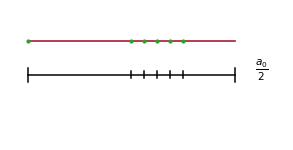

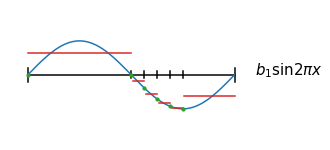

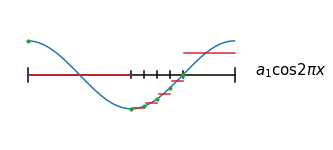

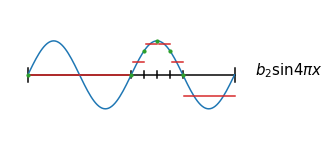

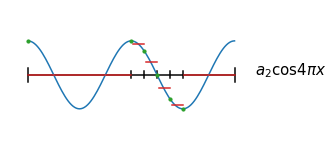

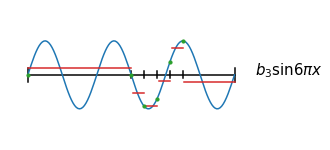

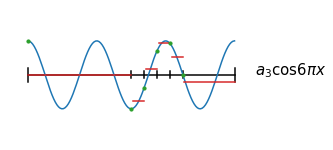

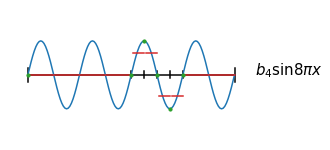

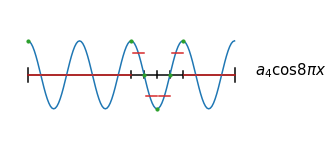

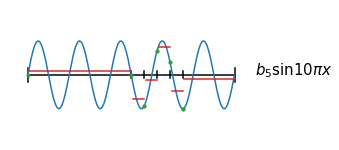

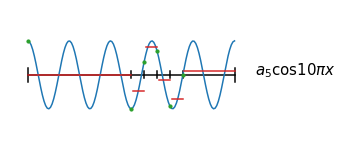

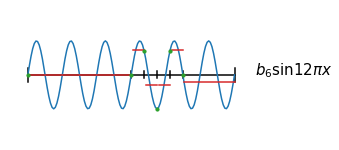

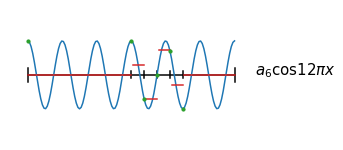

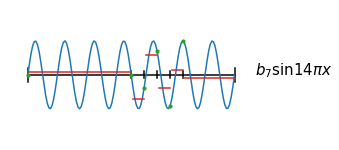

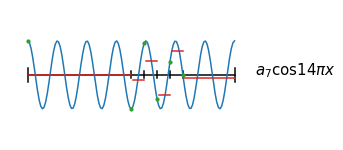

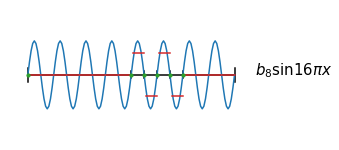

In [6]:
xCell, waves = WT.MakeWaves(nh, xBound)
xNode, wavesNode = MakeAMRNodeWaves(nh, xBound)
PT.PlotWaves(nh, waves, xNode, wavesNode, xBound, plotNode = True)

In [7]:
blah = np.eye(5)
bluh = np.zeros((5, 3), float)
print(bluh)
print(np.append(blah, bluh).reshape(8, 5).T)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


In [8]:
M = np.arange(16).reshape(4, 4)
O = M
O.T[::4] = 0
print(O)

[[ 0  1  2  3]
 [ 0  5  6  7]
 [ 0  9 10 11]
 [ 0 13 14 15]]


To go from fine to coarse, the term would be averaging down. For example, it would 0.5:0.5 for a refinement ratio of 2. This is exact for finite-volume.

To go from coarse to fine, there are two options. Piecewise constant, and piecewise linear. The piecewise linear takes neighboring values to interpolate to fine cell averages. advection

In [9]:
class Person:
  def __init__(self, age, name = 'Jan'):
    self.name = name
    self.age = age

  def myfunc(self):
    print("Hello my name is " + self.name)

p1 = Person(36)
p1.myfunc()

Hello my name is Jan


In [22]:
cells = [[1], [2], [4, 5], [8, 9, 11]]
print(len(cells[2]))
for i in cells:
    print(i)
xPiece = np.linspace(1, 5, num = 5)

2
[1]
[2]
[4, 5]
[8, 9, 11]


In [102]:
class Grid:
    def __init__(self, nh_min, cells = [], refRatio = 2):
        errorLoc = 'ERROR:\nBasicTools:\nGrid:\n'
        errorMess = BT.CheckNumber(nh_min, nhName = 'nh_min')
        if (errorMess != ''):
            sys.exit(errorLoc + errorMess)
        errorMess = BT.CheckNumber(refRatio, nhName = 'refRatio')
        if (errorMess != ''):
            sys.exit(errorLoc + errorMess)
        
#         for i in range(loops):
#             if (len(bounds[i]) != 2):
#                 problem = 3
#             if (bounds[i][0] > bounds[i][1]):
#                 problem = 4
#             if ((bounds[i][0] > nh_min * (2**(i + 1))) or (bounds[i][1] > nh_min * (2**(i + 1)))):
#                 problem = 5
#         nh_min = bounds[0][1]
        loops = len(cells)
#         if (problem == 3):
#             sys.exit('ERROR:\nBasicTools:\nMakeXY:\nAll elements in xBounds must be of length 2!')
#         if (problem == 4):
#             sys.exit('ERROR:\nBasicTools:\nMakeXY:\nLower-bound values in xBounds greater than upper bounds!')
#         if (problem == 5):
#             sys.exit('ERROR:\nBasicTools:\nMakeXY:\nValues in xBounds must correspond to the grid spacing of their respective level!')
        x = []
        patches = [[] for i in range(loops + 1)]
        patches[0] = np.linspace(0., 1., num = nh_min + 1)
        x = np.append(x, patches[0])
        nh_max = nh_min
        spots = nh_min
        for i in range(loops):
            nh_max = nh_max * refRatio
            if (i == 0):
                print((np.asarray(cells[i]) <= spots).all())
            else:
                checkLocations = []
                for k in range(spots):
                    for l in range(refRatio):
                        print(i, k, l)
                        # print(np.asarray(cells[i]) == (refRatio * cells[i - 1][k]) + l)
                        loc = np.where(np.asarray(cells[i]) == (refRatio * cells[i - 1][k]) + l)[0]
                        print()
                        if len(loc != 0):
                            checkLocations = np.append(checkLocations, loc)
                print(checkLocations)
            print('')
            spots = len(cells[i])
            if (spots == 1):
                regions = spots
                cellPieces = [[cells[i][0], cells[i][0]]]
            else:
                upper = np.asarray(cells[i][1:spots])
                lower = np.asarray(cells[i][0:spots - 1])
                cutWhere = np.append(np.where(lower != upper - 1)[0], spots - 1)
                regions = len(cutWhere)
                cellPieces = [[] for j in range(regions)]
                first = 0
                for j in range(regions):
                    last = cutWhere[j]
                    cellPieces[j] = [cells[i][first], cells[i][last]]
                    first = last + 1
            patches[i + 1] = [[] for j in range(regions)]
            for j in range(regions):
                rangeVal = cellPieces[j][1] - cellPieces[j][0] + 1
                n = rangeVal * refRatio
                h = rangeVal / (n * (refRatio**(i + 1)))
                xMin = h * refRatio * cellPieces[j][0]
                xMax = h * refRatio * (cellPieces[j][1] + 1)                    
                patches[i + 1][j] = np.linspace(xMin, xMax, num = n + 1)
                x = sorted(set(np.append(x, patches[i + 1][j])))
        
        x = np.asarray(x)
        n_max = len(x)
        y = np.zeros(n_max, float)
        
        self.nh_min = nh_min
        self.nh_max = nh_max
        self.cells = cells
        self.refRatio = refRatio
        self.x = x
        self.y = y
        self.patches = patches
#     def AddCell(self, newCell):
        
omega = Grid(2, cells = cells)
print('')
print(omega.x)

True

1 0 0

1 0 1

[0.]

2 0 0

2 0 1

[0. 1.]

3 0 0

3 0 1

3 1 0

3 1 1

[0. 1. 2.]


[0.      0.5     0.53125 0.5625  0.59375 0.625   0.6875  0.71875 0.75
 1.     ]


In [12]:
BT.CheckSize(2, omega.x)

'n does not match size of matrica!'

In [13]:
blah = [[] for i in range(5)]
blah[0] = (0, 1)
print(blah)

[(0, 1), [], [], [], []]


In [14]:
class P:

    def __init__(self,x):
        self.x = x

    @property
    def x(self):
        return self.__x

    @x.setter
    def x(self, x):
        if x < 0:
            self.__x = 0
        elif x > 1000:
            self.__x = 1000
        else:
            self.__x = x

In [15]:
p1 = P(1001)
p1.x

1000

In [16]:
class family:
  members = list([])
  familyname=""
  def __init__ (self, familyname):
    self.familyname = familyname
  class person:
    name = ""
    age = 0
    def __init__(self,name,age):
      self.name = name
      self.age = age
    def getAge(self):
      return self.age
    def getName(self):
      return self.name
  def newperson(self, name, age=0):
    p1 = self.person(name,age)
    self.members.append(p1)
    print(p1)
  def getMembers(self):
    for member in self.members:
      print(member.getName())
  def getAges(self):
    for member in self.members:
      print(member.getAge())
  def averageAge(self):
    ages = []
    for member in self.members:
      ages.append(member.getAge())
    print("Average age: %s"%np.mean(ages))

gorton = family("Gorton")
gorton.newperson("Oliver",24)
gorton.averageAge()
gorton.newperson("Cole",20)
gorton.averageAge()
gorton.getMembers()

Average age: 24.0
Average age: 22.0
Oliver
Cole


In [140]:
cells = [[1], [2], [4, 5], [8, 9, 11], [20, 16, 17, 19, 22]]
class Grid:
    patches = list([])
    x = []
    xPatches = [[]]
    levels = 0
    cells = list([])
    def __init__(self, nh):
        errorLoc = 'ERROR:\nBasicTools:\nGrid:\n__init__:\n'
        self.AddCell(nh)
        self.nh_min = nh
        errorMess = BT.CheckNumber(self.nh_min, nhName = 'nh_min')
        if (errorMess != ''):
            sys.exit(errorLoc + errorMess)
    class Patch:
        def __init__(self, nh, refRatio, cell):
            nh = nh * refRatio
            h = 1. / nh
            if (cell == []):
                regions = 1
                cellPieces = [[0, nh - 1]]
                xPatch = [[]]
                cell = [0]
            else:
                spots = len(cell)
                if (spots == 1):
                    regions = spots
                    cellPieces = [[cell[0], cell[0]]]
                else:
                    upper = np.asarray(cell[1:spots])
                    lower = np.asarray(cell[0:spots - 1])
                    cutWhere = np.append(np.where(lower != upper - 1)[0], spots - 1)
                    regions = len(cutWhere)
                    cellPieces = [[] for j in range(regions)]
                    first = 0
                    for j in range(regions):
                        last = cutWhere[j]
                        cellPieces[j] = [cell[first], cell[last]]
                        first = last + 1
                xPatch = [[] for j in range(regions)]
            bounds = [[] for j in range(regions)]
            for j in range(regions):
                rangeVal = cellPieces[j][1] - cellPieces[j][0] + 1
                n = rangeVal * refRatio
                xMin = h * refRatio * cellPieces[j][0]
                xMax = h * refRatio * (cellPieces[j][1] + 1)
                xPatch[j] = np.linspace(xMin, xMax, num = n + 1)
                bounds[j] = np.asarray([xMin, xMax])
            self.nh = nh
            self.xPatch = xPatch
            self.cell = cell
            self.bounds = bounds
        def getNh(self):
            return self.nh
        def getRefRatio(self):
            return self.refRatio
        def getCell(self):
            return self.cell
        def getXPatch(self):
            return self.xPatch
    def AddCell(self, nh, refRatio = 1, cell = []):
        self.levels = self.levels + 1
        patch0 = self.Patch(nh, refRatio, cell)
        
        # ERROR CHECKS:
        
        errorLoc = 'ERROR:\nBasicTools:\nGrid:\nAddCell:\n'
        if (cell != []):
            errorMess = BT.CheckNumber(self.refRatio, nhName = 'refRatio')
            if (errorMess != ''):
                sys.exit(errorLoc + errorMess)
            for patchBound in patch0.bounds:
                both = False
                j = 0
                while ((not both) and (j < len(self.bounds))):
                    bound = self.bounds[j]
                    aboveLower = np.all(patchBound >= bound[0])
                    belowUpper = np.all(patchBound <= bound[1])
                    both = np.all([aboveLower, belowUpper])
                    j = j + 1
                if (not both):
                    errorMess = 'cell values out of range of previous patch!'
                    sys.exit(errorLoc + errorMess)
        else:
            refRatio = 1
        if (cell != sorted(cell)):
            errorMess = 'cell must be in number order!'
            sys.exit(errorLoc + errorMess)
        if (len(cell) != len(set(cell))):
            errorMess = 'cell contains repeats!'
            sys.exit(errorLoc + errorMess)
        
        # END OF ERROR CHECKS
        
        self.patches.append(patch0)
        xPatchesFiller = [[] for i in range(self.levels)]
        cellsFiller = [[] for i in range(self.levels)]
        for xPatch in patch0.xPatch:
            self.x = sorted(set(np.append(self.x, xPatch)))
        for i in range(self.levels):
            if (i == self.levels - 1):
                xPatchesFiller[i] = patch0.xPatch
                cellsFiller[i] = patch0.cell
            else:
                xPatchesFiller[i] = self.xPatches[i]
                cellsFiller[i] = self.cells[i]
        self.xPatches = xPatchesFiller
        self.cells = cellsFiller
        self.nh_max = patch0.nh
        self.refRatio = refRatio
        self.y = np.zeros(len(self.x), float)
        self.bounds = patch0.bounds
print(cells)
print('')
omega = Grid(2)
# omega.AddCell(2)
print(omega.nh_min, omega.nh_max, omega.levels)
print('')
for i in cells:
    print(i)
    omega.AddCell(omega.nh_max, 2, i)
    print(omega.nh_min, omega.nh_max, omega.levels)
    print('')
print('')
print(omega.xPatches)

[[1], [2], [4, 5], [8, 9, 11], [20, 16, 17, 19, 22]]

2 2 1

[1]
2 4 2

[2]
2 8 3

[4, 5]
2 16 4

[8, 9, 11]
2 32 5

[20, 16, 17, 19, 22]


SystemExit: ERROR:
BasicTools:
Grid:
AddCell:
cell values out of range of previous patch!

In [18]:
patch = list([])
blah = patch.append([5])
print(blah)

None
